In [1]:
%matplotlib inline
import os
import math
import numpy as np
import pandas as pd
from os.path import join as pjoin

import matplotlib.pyplot as plt
import cv2 as cv
from skimage.io import imshow, imread, imsave
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

work_dir = '.'
file_path = './face/'
label_data = './labels.csv'

In [2]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.preprocessing import normalize

Using TensorFlow backend.


In [3]:
pd_face = pd.read_csv('./face_index.csv')#, index_col=0)

In [4]:
pd_face.head()

,file_name,is_smile,yaw,pitch,roll,path
0,file0001.jpg,1,-0.021162,0.059530,-0.039662,./faces/file0001.jpg
1,file0002.jpg,1,-0.057745,0.083098,-0.094952,./faces/file0002.jpg
2,file0003.jpg,1,0.095993,0.028798,0.065996,./faces/file0003.jpg
3,file0004.jpg,1,0.000000,0.047124,0.171268,./faces/file0004.jpg
4,file0005.jpg,1,0.036073,0.043633,-0.181721,./faces/file0005.jpg


In [5]:
import mxnet as mx
from mtcnn_detector import MtcnnDetector
import cv2


def find_pts(img, verbose=0, is_show=False , is_rect=False, is_normalize=False):
#     img = imread(pd_face.iloc[9]['path'])
    detector = MtcnnDetector(model_folder='model', ctx=mx.cpu(0), num_worker = 4 , accurate_landmark = False)
    results = detector.detect_face(img)
    draw = img.copy()
    if results is not None:

        total_boxes = results[0]
        pts = results[1]
        boxes = []
        for i in range(len(pts)):
            boxes.append([])
            height  = pts[i][7]-pts[i][9]
            width = pts[i][4]-pts[i][3]
            boxes[-1].append(pts[i][3])
            boxes[-1].append(pts[i][8]+height/2*0.8)
            boxes[-1].append(pts[i][4])
            boxes[-1].append(pts[i][4]-height)
    if verbose > 0:
        print(f"image shape: {str(img.shape)}")
#         print("Number of faces detected: {}".format(len(dets)))
        
        for i in range(len(boxes)):
            print("Detection {}: Left: {} Top: {} Right: {} Bottom: {} ".format(
                i, boxes[i][0], boxes[i][1], boxes[i][2], boxes[i][3]))
            print(f"aspect_ratio:{(boxes[i][3] - boxes[i][1]) / (boxes[i][2] -  boxes[i][0])}")
    if is_rect:
        for i in range(len(boxes)):
            img = cv.rectangle(draw, (int(boxes[i][0]), int(boxes[i][1])), (int(boxes[i][2]), int(boxes[i][3])), (255, 0, 0), 1)
#     shape = predictor(img, face)
        # use 15 points
    for i in range(len(pts)):
        if is_rect:
            for j in range(5):
                cv2.circle(draw, (pts[i][j], pts[i][j + 5]), 1, (0, 0, 255), 2)
    
        break
        
    if is_show:
        imshow(draw)
    
    return pts

def get_face_mouth_position(img_gen, is_compress=False, width=96, height=90,
                            verbos=1, pt_length=5, is_debug=False, is_normalize=False):

    columns = [x for x in range(pt_length)]
    columns.insert(0, 'index')
    columns.insert(1, 'path')
    pts = pd.DataFrame(columns=columns)
    
    for index, img_path in img_gen:
        if is_debug and index > 20:
            break
        try:
            if is_compress:
                img = normalize_img(img_path, is_grey=True, is_vectorize=False, 
                                    width=width, height=height)
            else:
                img = imread(img_path)
                img = img.copy()
#             face, mouth = find_face_mouth(img=img)

            fpt = find_pts(img=img, is_normalize=is_normalize)

            if len(fpt) > 0:
#                 print(len(fpt))
                df = pd.DataFrame(np.array(fpt).reshape((1,-1)))
                df['index'] = index
                df['path'] = img_path
                pts = pts.append(df, ignore_index=True)
            else:
                if verbos>0:
                    print('No face/mouth found in %s' % img_path)        
        except:
            print(f"error found for {img_path}")
    
    return pts

def normalize_img(filename, is_grey=True, is_vectorize=False, width=96, height=90):
    size = WIDTH, HEIGHT # (width, height)
    im = Image.open(filename) 
    resized_im = im.resize(size, Image.ANTIALIAS) # resize image
    result = np.array(resized_im)
#     if is_grey:
#         im_grey = resized_im.convert('L') # convert the image to *greyscale*
#         im_array = np.array(im_grey) # convert to np array
#         result = im_array
    if is_vectorize:
        oned_array = result.reshape(size[0] * size[1])
        result = oned_array
    return result#np.array(resized_im)#oned_array

def img_generator(data):
    for i in range(len(data)):
        im_info = data.iloc[i]
        index = im_info['index']
        path = im_info['path']
        yield index, path

def get_partial(img, x, y, w, h):
    return img[y:y+h, x:x+w]

def check_creat_dir(save_path):
    dir_path = os.path.dirname(save_path)
    if not os.path.exists(dir_path):
        print('create folder... %s' % dir_path)
        os.makedirs(dir_path)

In [6]:
pd_face = pd.read_csv('./face_index.csv')#, index_col=0)

In [7]:
WIDTH, HEIGHT = 96, 90 #48*2, 45*2
pd_face.head()

,file_name,is_smile,yaw,pitch,roll,path
0,file0001.jpg,1,-0.021162,0.059530,-0.039662,./faces/file0001.jpg
1,file0002.jpg,1,-0.057745,0.083098,-0.094952,./faces/file0002.jpg
2,file0003.jpg,1,0.095993,0.028798,0.065996,./faces/file0003.jpg
3,file0004.jpg,1,0.000000,0.047124,0.171268,./faces/file0004.jpg
4,file0005.jpg,1,0.036073,0.043633,-0.181721,./faces/file0005.jpg


/Users/gaotao/anaconda3/lib/python3.6/site-packages/mxnet/model.py:928: DeprecationWarning: mxnet.model.FeedForward has been deprecated. Please use mxnet.mod.Module instead.
  **kwargs)


image shape: (90, 96, 3)
Detection 0: Left: 36.86933517456055 Top: 57.9566535949707 Right: 57.513526916503906 Bottom: 65.80784606933594 
aspect_ratio:0.380309995785098


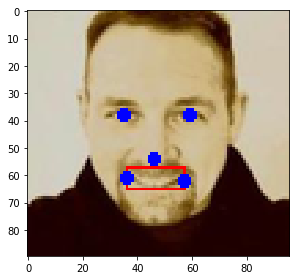

In [8]:
img = normalize_img(pd_face.iloc[26]['path'], is_vectorize=False, width=WIDTH, height=HEIGHT)
# img = imread(pd_face.iloc[23]['path'])
_ = find_pts(img,#imread(pd_face.iloc[23]['path']), 
             is_show=True, is_rect=True, verbose=1)

### generate labels using dlib

In [178]:
def get_labels(img_gen=None, is_debug=False, is_save=False):
    
    if img_gen == None:
        img_gen = img_generator(pd_face.reset_index())
    
    labels_pd = get_face_mouth_position(img_gen, verbos=0, is_normalize=False, is_debug=is_debug,#True, 
                                        is_compress=True, width=WIDTH, height=HEIGHT)
    # save data
    if is_save:
        labels_pd.to_csv('./face_5pt_data.csv', index=False)
    
    return labels_pd

In [214]:
# labels_pd = get_labels(is_debug=True, is_save=False)
labels_pd = get_labels(is_debug=False, is_save=True)

In [215]:
labels_pd.head()

,index,path,0,1,2,3,4,5,6,7,8,9
0,0,./faces/file0001.jpg,61,39,54,40,35,42.0,42.0,41.0,50.0,53.0
1,1,./faces/file0002.jpg,59,39,54,40,39,41.0,44.0,41.0,49.0,51.0
2,3,./faces/file0004.jpg,58,42,51,42,35,39.0,41.0,40.0,45.0,53.0
3,4,./faces/file0005.jpg,57,39,52,40,35,43.0,42.0,42.0,49.0,52.0
4,5,./faces/file0006.jpg,76,40,67,41,44,40.0,53.0,41.0,60.0,54.0


### change img to csv format. append labels

In [216]:
def get_both_img_data_lables(labels_pd, is_save=False):
    imgs = []
    for i_index in range(len(labels_pd)):
        img = normalize_img(labels_pd.iloc[i_index].path, is_grey=True, is_vectorize=True, width=WIDTH, height=HEIGHT)#False)
        imgs.append(img)
    imgs = np.array(imgs)
    face_data_pd = pd.DataFrame(imgs)

    face_rec_data_pd = labels_pd.drop('index', axis=1).join(face_data_pd, lsuffix='_lb')
    if is_save:
        face_rec_data_pd.to_csv('./face_5pt_img_data.zip', index=False, compression='zip')
    return face_rec_data_pd

In [217]:
# face_rec_data_pd = get_both_img_data_lables(labels_pd, is_save=False)
face_rec_data_pd = get_both_img_data_lables(labels_pd, is_save=True)

In [218]:
face_rec_data_pd.head()

,path,0_lb,1_lb,2_lb,3_lb,4_lb,5_lb,6_lb,7_lb,8_lb,...,8630,8631,8632,8633,8634,8635,8636,8637,8638,8639
0,./faces/file0001.jpg,61,39,54,40,35,42.0,42.0,41.0,50.0,...,200,195,197,194,195,199,202,200,202,202
1,./faces/file0002.jpg,59,39,54,40,39,41.0,44.0,41.0,49.0,...,195,197,201,214,216,214,194,190,199,203
2,./faces/file0004.jpg,58,42,51,42,35,39.0,41.0,40.0,45.0,...,17,17,17,17,17,17,17,17,16,16
3,./faces/file0005.jpg,57,39,52,40,35,43.0,42.0,42.0,49.0,...,51,48,39,38,41,47,53,47,53,50
4,./faces/file0006.jpg,76,40,67,41,44,40.0,53.0,41.0,60.0,...,77,88,88,92,105,103,107,113,122,128


**read data from saved data**

In [5]:
WIDTH, HEIGHT = 96, 90 #48*2, 45*2

In [49]:
labes_pd = pd.read_csv('./face_5pt_data.csv')
face_rec_data_pd = pd.read_csv('./face_5pt_img_data.zip')

### revert data & check accuracy

In [6]:
def get_inver_norm_pts(img_lb, width=WIDTH, height=HEIGHT):
    img_lb_xs = img_lb[np.arange(0, 9, 2)]
    img_lb_ys = img_lb[np.arange(1, 11, 2)]

    pts = []
    for x,y in zip(img_lb_xs, img_lb_ys):
#         x *= width
#         y *= height
        x = int(round(x))
        y = int(round(y))
        pts.append([x, y])
    pts = np.array(pts)
    return pts

def find_face_param(pts):
    eye_width = abs(pts[0][0] - pts[1][0])
    face_x_left = pts[0][0] - eye_width * 4.3
    face_width = eye_width*5.3

    eye_y_avg = np.average(pts[0:4, 1])
    eye_fmid_dist = pts[4][1] - eye_y_avg
    face_y_up = eye_y_avg - eye_fmid_dist
    face_height = eye_fmid_dist * 3.3
    
    return int(math.floor(face_x_left)), int(math.floor(face_y_up)), int(math.ceil(face_width)), int(math.ceil(face_height))

**reverted data**

In [16]:
img2 = normalize_img('./faces/file0001.jpg', is_grey=True, is_vectorize=False, 
                                    width=WIDTH, height=HEIGHT)

In [26]:
img2

array([[ 15,  20,  25, ..., 109, 111, 114],
       [ 33,  29,  29, ..., 109, 111, 114],
       [100,  79,  58, ..., 109, 111, 114],
       ...,
       [192, 190, 194, ..., 204, 196, 204],
       [194, 193, 193, ..., 203, 198, 201],
       [197, 197, 191, ..., 200, 202, 202]], dtype=uint8)

In [33]:
img = img.astype('uint8')

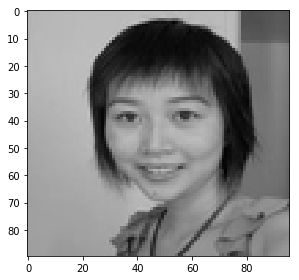

In [52]:
imshow(img)

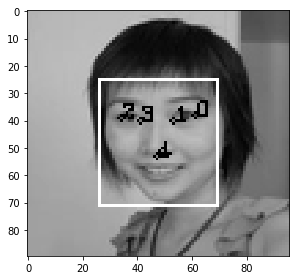

In [51]:
im_idx = 13
img = face_rec_data_pd.iloc[:,11:].iloc[im_idx].astype('uint8').values.reshape(HEIGHT, WIDTH)
img_lb = face_rec_data_pd.iloc[:,1:11].iloc[im_idx]
pts = get_inver_norm_pts(img_lb)
# for x, y in zip(pts[:,0], pts[:,1]):
img_cp = img.copy()
for i, pt in enumerate(pts):
    img_cp = cv.circle(img_cp, (pt[0], pt[1]), 1, (0,0,255), 1)
    cv.putText(img_cp, str(i), (pt[0], pt[1]), cv.FONT_HERSHEY_COMPLEX, 0.25, (0,255,0), 1)
    
fx, fy, fw, fh = find_face_param(pts)
cv.rectangle(img_cp, (fx, fy), (fx+fw, fy+fh), (255, 0, 0), 1)
    
imshow(img_cp)

**orginal plot**

image shape: (90, 96)
Number of faces detected: 1
Detection 0: Left: 26 Top: 26 Right: 69 Bottom: 70 
aspect_ratio:1.0232558139534884


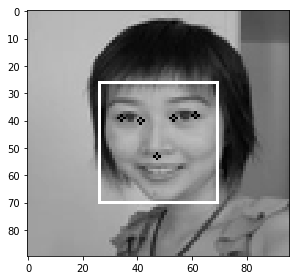

In [231]:
img_lb = find_pts(img, is_show=True, is_rect=True, verbose=1, is_normalize=False)
# if len(img_lb) > 0:
#     pts = get_inver_norm_pts(np.array(img_lb))
#     plt.scatter(pts[:,0], pts[:,1])

In [232]:
print(f"in-file: {pts.reshape(-1).tolist()}")
print(f"rec    : {img_lb}")

in-file: [61, 38, 53, 40, 34, 39, 41, 40, 47, 53]
rec    : [61, 38, 53, 39, 34, 39, 41, 40, 47, 53]


In [326]:
img.shape

(90, 96)

## train model

In [160]:
# labels_pd = face_rec_data_pd.iloc[:,:9]

In [290]:
face_rec_data_pd = pd.read_csv('./face_5pt_img_data.zip')

In [173]:
face_data = face_rec_data_pd.iloc[:,11:].astype('uint8')
face_labels_pd = face_rec_data_pd.iloc[:,1:11]

In [184]:
face_data = face_data / 255

In [185]:
face_data = face_data.values.reshape(-1, HEIGHT, WIDTH, 1)

In [205]:
face_labels_pd['cx'] = (face_labels_pd['fx']+face_labels_pd['fw']) / 2
face_labels_pd['cy'] = (face_labels_pd['fy']+face_labels_pd['fh']) / 2

In [207]:
face_labels_pd = face_labels_pd[['cx', 'cy']]

In [208]:
random_seed = 5012
X_train, X_val, Y_train, Y_val = train_test_split(face_data, face_labels_pd, test_size=0.3, random_state=random_seed)

In [210]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='Same',
                activation='relu', input_shape=(HEIGHT, WIDTH, 1)))
# model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(2,2), padding='Same',
                activation='relu'))
# model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(2,2), padding='Same',
                activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(filters=64, kernel_size=(2,2), padding='Same',
#                 activation='relu'))
# model.add(BatchNormalization())
# model.add(Conv2D(filters=64, kernel_size=(2,2), padding='Same',
#                 activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPool2D(pool_size=(2,2), strides=(1,1)))
# model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dense(units=2, activation='relu'))

In [211]:
# define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# compile the model
model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 45, 48, 32)        320       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 45, 48, 64)        8256      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 45, 48, 128)       32896     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 22, 24, 128)       0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 67584)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 1024)              69207040  
_________________________________________________________________
dropout_10 (Dropout)         (None, 1024)              0         
__________

In [212]:
datagen = ImageDataGenerator(featurewise_center=False,
                            samplewise_center=False,
                            featurewise_std_normalization=False,
                            samplewise_std_normalization=False,
                            zca_whitening=False,
                            rotation_range=10,
                            zoom_range=0.1,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            horizontal_flip=False,
                            vertical_flip=False)
datagen.fit(X_train)

In [213]:
# set a early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=2)
# set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                           patience=3,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr=0.0001)
epochs = 30
batch_size = 170

In [222]:
# # without data augmentation
# history = model.fit(X_train, Y_train, batch_size=batch_size,
#                     epochs=epochs, validation_data=(X_val, Y_val), verbose=2)
# with data augmentation
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size), 
                              epochs=epochs, 
                              validation_data=(X_val, Y_val), 
                              verbose=2, 
#                               steps_per_epoch=X_train[0], 
                              callbacks=[learning_rate_reduction])

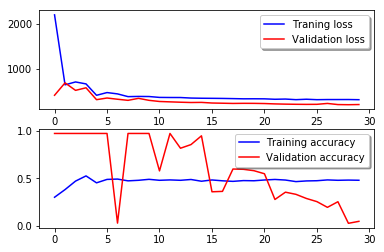

In [204]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label='Traning loss')
ax[0].plot(history.history['val_loss'], color='r', label='Validation loss', axes=ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label='Training accuracy')
ax[1].plot(history.history['val_acc'], color='r', label='Validation accuracy')
legend = ax[1].legend(loc='best', shadow=True)
fig.show()